In [39]:
!pip install tensorflow==2.13.0
!pip install tensorflow-addons==0.21.0


  Using cached tensorflow-2.13.0-cp311-cp311-win_amd64.whl.metadata (2.6 kB)
  Using cached keras-2.13.1-py3-none-any.whl.metadata (2.4 kB)
Using cached tensorflow-2.13.0-cp311-cp311-win_amd64.whl (1.9 kB)
Using cached keras-2.13.1-py3-none-any.whl (1.7 MB)
  Using cached tensorflow_addons-0.21.0-cp311-cp311-win_amd64.whl.metadata (1.8 kB)
Using cached tensorflow_addons-0.21.0-cp311-cp311-win_amd64.whl (719 kB)


EfficientNet

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from tensorflow.keras.utils import plot_model

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D



print("TensorFlow Version:", tf.__version__)

d:\New folder\.venv\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


TensorFlow Version: 2.13.0


In [2]:
import tensorflow as tf
print(tf.__version__)


2.13.0


In [3]:
base_dir = "../Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [4]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 128
IMAGE_SIZE = [128, 128]
DIM = (IMG_SIZE, IMG_SIZE)

In [5]:


ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)



Found 8231 images belonging to 4 classes.


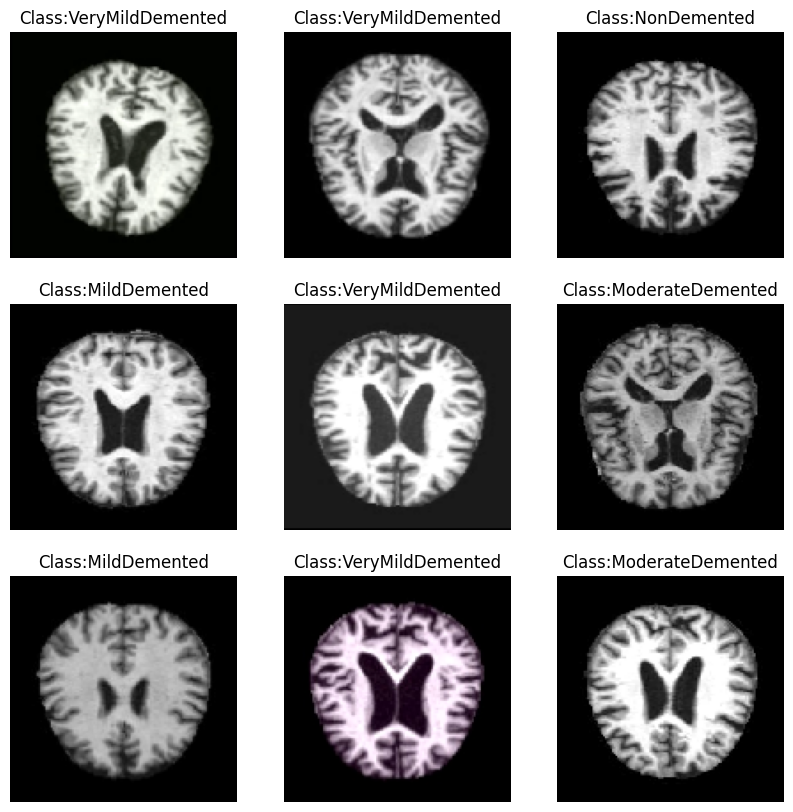

In [6]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            # idx = randint(0, 6400)
            idx = randint(0, x.shape[0] - 1)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

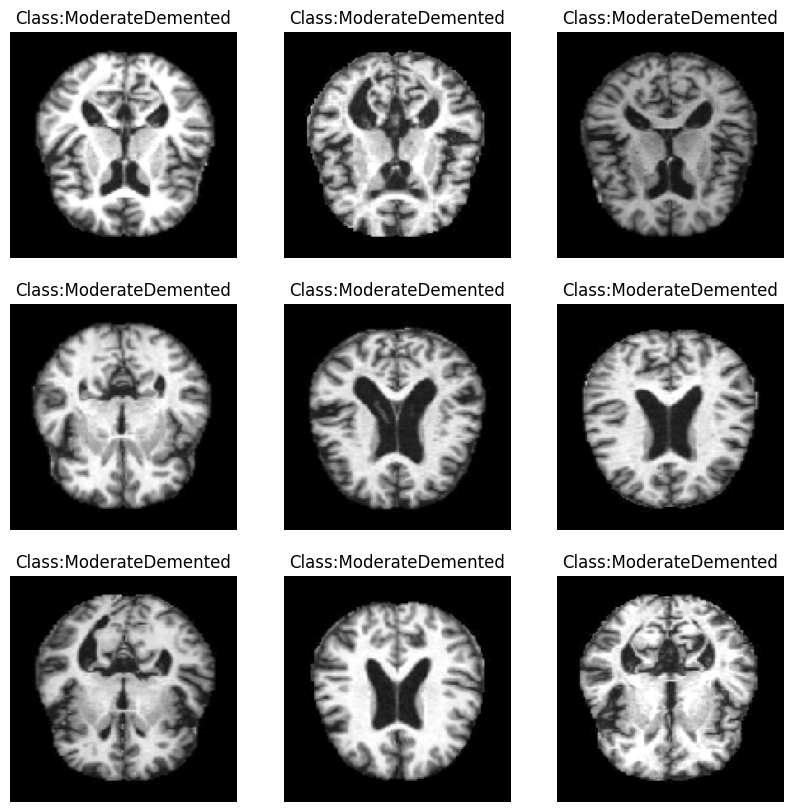

In [7]:
show_images(train_data_gen)

In [8]:

train_data, train_labels = train_data_gen.next()

In [9]:
print("Loaded data shape:", train_data.shape, train_labels.shape)

Loaded data shape: (6500, 128, 128, 3) (6500, 4)


In [10]:
# --- Stratified Data Splitting ---
# Convert one-hot labels to class indices for stratification
labels_indices = np.argmax(train_labels, axis=1)

In [11]:
# Split into training and test sets (20% for testing)
train_data, test_data, train_labels, test_labels = train_test_split(
    train_data, train_labels,
    test_size=0.2,
    random_state=42,
    stratify=labels_indices
)



In [12]:
# Further split training data into training and validation sets (20% for validation)
train_labels_indices = np.argmax(train_labels, axis=1)
train_data, val_data, train_labels, val_labels = train_test_split(
    train_data, train_labels,
    test_size=0.2,
    random_state=42,
    stratify=train_labels_indices
)

In [13]:
print("Final splits:")
print("Train:", train_data.shape, np.unique(np.argmax(train_labels, axis=1), return_counts=True))
print("Validation:", val_data.shape, np.unique(np.argmax(val_labels, axis=1), return_counts=True))
print("Test:", test_data.shape, np.unique(np.argmax(test_labels, axis=1), return_counts=True))


Final splits:
Train: (4160, 128, 128, 3) (array([0, 1, 2, 3], dtype=int64), array([ 946,  840, 2048,  326], dtype=int64))
Validation: (1040, 128, 128, 3) (array([0, 1, 2, 3], dtype=int64), array([237, 210, 512,  81], dtype=int64))
Test: (1300, 128, 128, 3) (array([0, 1, 2, 3], dtype=int64), array([296, 262, 640, 102], dtype=int64))


In [14]:
# --- Compute Class Weights ---
from sklearn.utils.class_weight import compute_class_weight

train_labels_indices = np.argmax(train_labels, axis=1)
class_weights = compute_class_weight('balanced',
                                     classes=np.unique(train_labels_indices),
                                     y=train_labels_indices)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: 1.0993657505285412, 1: 1.2380952380952381, 2: 0.5078125, 3: 3.1901840490797544}


In [ ]:
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import tensorflow_addons as tfa

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Load EfficientNetB7 base
base_model = EfficientNetB1(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3))
base_model.trainable = True  # Enable fine-tuning

# Freeze the first 200 layers (experiment with the number)
for layer in base_model.layers[:100]:
    layer.trainable = False

# Custom classification head
x = base_model.output

x = Conv2D(16, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Conv2D(16, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(padding='same')(x)  # Changed padding to 'same'

x = Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(padding='same')(x)  # Changed padding to 'same'

x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
out = Dense(4, activation='softmax')(x)

# Create model
finetuned_model = Model(inputs=base_model.input, outputs=out, name="EffNetB7_CustomHead")

# --- Custom Metrics ---
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='acc'),
    tf.keras.metrics.AUC(name='auc'), 
    tfa.metrics.F1Score(num_classes=4)  # Using TensorFlow Addons F1Score
]

# --- Callbacks ---
CALLBACKS = [my_callback, early_stop]

# Compile
finetuned_model.compile(optimizer=Adam(learning_rate=1e-4),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# Show model summary
finetuned_model.summary()


checkpoint = ModelCheckpoint('finetuned_custom_efficientnetb7.h5', monitor='val_accuracy',
                             save_best_only=True, verbose=1)




27018416/27018416 [==============================] - 6s 0us/step
Model: "EffNetB7_CustomHead"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 128, 128, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (R

In [16]:
# Train
history_effnetb7 = finetuned_model.fit(
    train_data, train_labels,
    validation_data=(val_data, val_labels),
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30
130/130 [==============================] - ETA: 0s - loss: 1.6692 - accuracy: 0.2844
Epoch 1: val_accuracy improved from -inf to 0.27788, saving model to finetuned_custom_efficientnetb7.h5


d:\New folder\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


130/130 [==============================] - 266s 2s/step - loss: 1.6692 - accuracy: 0.2844 - val_loss: 1.4941 - val_accuracy: 0.2779
Epoch 2/30
130/130 [==============================] - ETA: 0s - loss: 1.4953 - accuracy: 0.3517
Epoch 2: val_accuracy did not improve from 0.27788
130/130 [==============================] - 237s 2s/step - loss: 1.4953 - accuracy: 0.3517 - val_loss: 1.8048 - val_accuracy: 0.2048
Epoch 3/30
130/130 [==============================] - ETA: 0s - loss: 1.3853 - accuracy: 0.4267
Epoch 3: val_accuracy did not improve from 0.27788
130/130 [==============================] - 235s 2s/step - loss: 1.3853 - accuracy: 0.4267 - val_loss: 1.7036 - val_accuracy: 0.2346
Epoch 4/30
130/130 [==============================] - ETA: 0s - loss: 1.3096 - accuracy: 0.4500
Epoch 4: val_accuracy improved from 0.27788 to 0.45769, saving model to finetuned_custom_efficientnetb7.h5
130/130 [==============================] - 236s 2s/step - loss: 1.3096 - accuracy: 0.4500 - val_loss: 1.337

In [17]:
# Evaluate
loss, accuracy = finetuned_model.evaluate(test_data, test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

41/41 [==============================] - 26s 630ms/step - loss: 0.7194 - accuracy: 0.7523
Test Accuracy: 75.23%


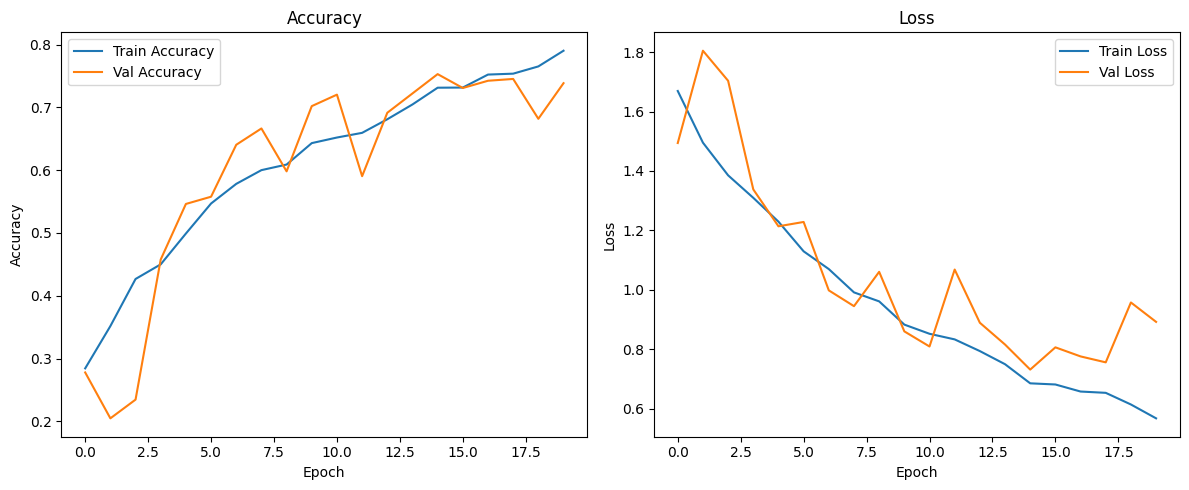

In [18]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history_effnetb7)


41/41 [==============================] - 28s 616ms/step


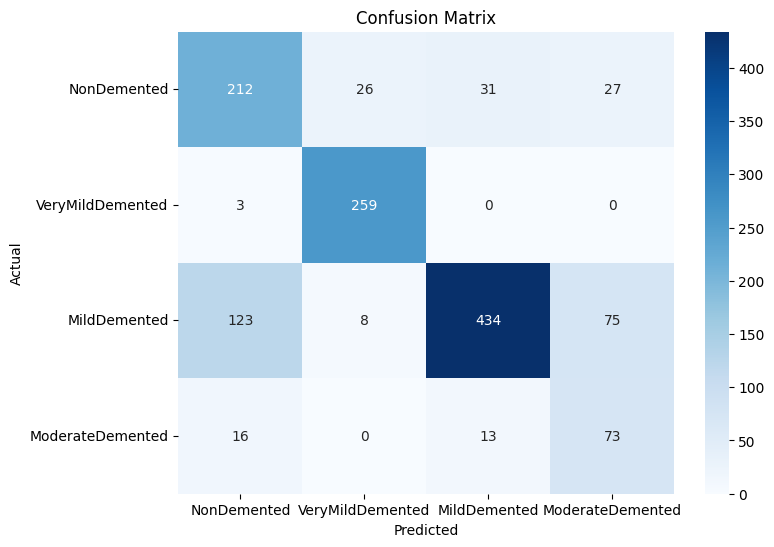

                  precision    recall  f1-score   support

     NonDemented       0.60      0.72      0.65       296
VeryMildDemented       0.88      0.99      0.93       262
    MildDemented       0.91      0.68      0.78       640
ModerateDemented       0.42      0.72      0.53       102

        accuracy                           0.75      1300
       macro avg       0.70      0.77      0.72      1300
    weighted avg       0.79      0.75      0.76      1300



In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Predict on test data
y_pred_probs = finetuned_model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(test_labels, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=CLASSES))


In [20]:
finetuned_model.save('finetuned_effnetbX_head.h5')  # X = B7 or B1/B2 depending on what you used


d:\New folder\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


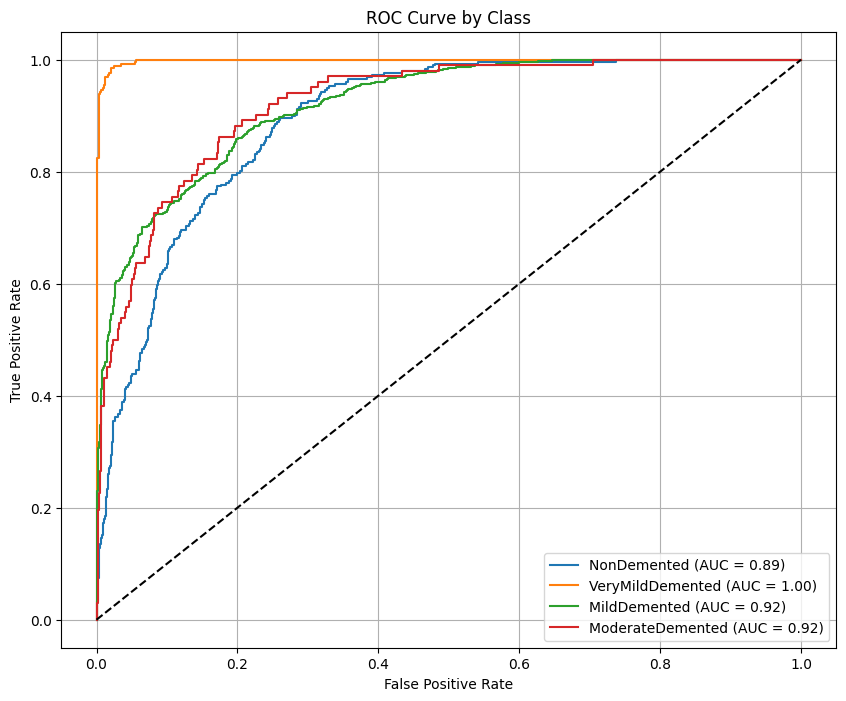

In [22]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
plt.figure(figsize=(10, 8))
for i in range(4):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{CLASSES[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve by Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


Combining 2 Models: CNN, EfficientNet

In [24]:
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Load models
model1 = load_model('finetuned_effnetbX_head.h5')  # EfficientNetB1/B2/B7
model2 = load_model('firstmodel.h5')    # Your custom CNN

# Predict on test set
pred1 = model1.predict(test_data)
pred2 = model2.predict(test_data)

# Soft Voting: Average predictions
ensemble_preds = (pred1 + pred2) / 2
ensemble_classes = np.argmax(ensemble_preds, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Evaluate
ensemble_accuracy = accuracy_score(true_classes, ensemble_classes)
print(f"✅ Ensemble Accuracy: {ensemble_accuracy * 100:.2f}%\n")

print("📊 Classification Report:")
print(classification_report(true_classes, ensemble_classes, target_names=CLASSES))


41/41 [==============================] - 8s 181ms/step
✅ Ensemble Accuracy: 90.46%

📊 Classification Report:
                  precision    recall  f1-score   support

     NonDemented       0.81      0.93      0.86       296
VeryMildDemented       0.98      0.99      0.99       262
    MildDemented       0.92      0.94      0.93       640
ModerateDemented       0.93      0.42      0.58       102

        accuracy                           0.90      1300
       macro avg       0.91      0.82      0.84      1300
    weighted avg       0.91      0.90      0.90      1300



In [26]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score

ensemble_classes = np.argmax(ensemble_preds, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Metrics
acc = accuracy_score(true_classes, ensemble_classes)
f1 = f1_score(true_classes, ensemble_classes, average='weighted')
print(f"✅ Ensemble Accuracy: {acc * 100:.2f}%")
print(f"🎯 F1 Score (weighted): {f1:.4f}")

# Classification report
print("\n📋 Classification Report:")
print(classification_report(true_classes, ensemble_classes, target_names=CLASSES))


✅ Ensemble Accuracy: 90.46%
🎯 F1 Score (weighted): 0.8981

📋 Classification Report:
                  precision    recall  f1-score   support

     NonDemented       0.81      0.93      0.86       296
VeryMildDemented       0.98      0.99      0.99       262
    MildDemented       0.92      0.94      0.93       640
ModerateDemented       0.93      0.42      0.58       102

        accuracy                           0.90      1300
       macro avg       0.91      0.82      0.84      1300
    weighted avg       0.91      0.90      0.90      1300



d:\New folder\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


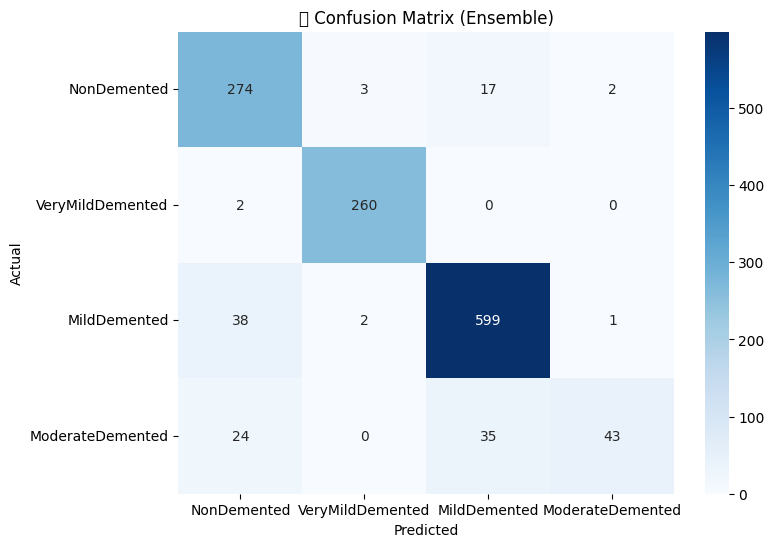

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_classes, ensemble_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("📊 Confusion Matrix (Ensemble)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


d:\New folder\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


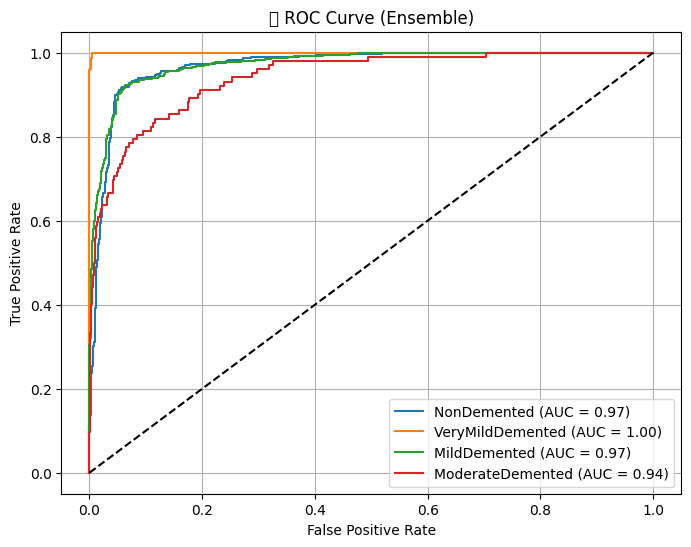

In [28]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize labels
true_binarized = label_binarize(true_classes, classes=list(range(len(CLASSES))))

plt.figure(figsize=(8, 6))
for i in range(len(CLASSES)):
    fpr, tpr, _ = roc_curve(true_binarized[:, i], ensemble_preds[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{CLASSES[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title('📈 ROC Curve (Ensemble)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [38]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, AUC
import tensorflow as tf

# Load individual models
custom_model = load_model("firstmodel.h5")
finetuned_model = load_model("finetuned_effnetbX_head.h5")

# Input shape (Adjust if necessary)
input_tensor = Input(shape=(128, 128, 3))

# Get outputs from both models
output1 = custom_model(input_tensor)
output2 = finetuned_model(input_tensor)

# Average the predictions
ensemble_output = Average()([output1, output2])

# Create the final ensemble model
ensemble_model = Model(inputs=input_tensor, outputs=ensemble_output, name="EnsembleModel")

# Compile the ensemble model
ensemble_model.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy(), AUC()]
)

# Now, evaluate the ensemble model (optional, if you want to check performance)
# Assuming you have test_data and test_labels
loss, accuracy, auc = ensemble_model.evaluate(test_data, test_labels, verbose=1)

# Print evaluation results
print(f"Ensemble Test Accuracy: {accuracy * 100:.2f}%")
print(f"AUC: {auc:.4f}")
print(f"Loss: {loss:.4f}")

# Save the ensemble model after compilation
ensemble_model.save("ensemble_model_compiled.h5")


41/41 [==============================] - 41s 934ms/step - loss: 0.8473 - categorical_accuracy: 0.9046 - auc: 0.9819
Ensemble Test Accuracy: 90.46%
AUC: 0.9819
Loss: 0.8473
